In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
import metpy.calc as mpcalc

#from Plot_tools import *
from File_tools import *

import pickle

_nthreads = 2


In [2]:
w_thresh = 5.0
cref_thresh = 35.
percent = (50,90,95)

in_dir  = "/work/wicker/Odin_scr/solo"
out_dir = "/work/wicker/Odin_scr/solo"
prefix  = {"solo": "squall_3km", "wrf": "squall_3km", "cm1": "squall_3km"}

allcape = ("C2000","C3500")
allshear = ("06","12", "18")

solo  = {}
cm1   = {}
wrf   = {}

for shear in allshear:
    for cape in allcape:
        
        label = "%s_%s" % (cape, shear)

        solo_file = str(os.path.join(in_dir, "%s_%s" % (prefix['solo'], label)))
        solo[label] = generate_ideal_profiles(solo_file, filename="atmos_hifreq.nc", model_type='fv3_solo', w_thresh = w_thresh, cref_thresh = cref_thresh,
                                                            percentiles=percent, zhgts = 250. + 250.*np.arange(100))
        
        wrf_file = str(os.path.join("/work/wicker/WRF/WRF/test/em_quarter_ss", "%s_%s" % (prefix['wrf'], label)))
        wrf[label] = generate_ideal_profiles(wrf_file, model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, 
                                                          percentiles=percent, compDBZ=True, zhgts = 250. + 250.*np.arange(100))
                 
        cm1_file = str(os.path.join("/work/wicker/Odin_scr/cm1r20.3/run", "%s_%s" % (prefix['cm1'], label)))
        cm1[label] = generate_ideal_profiles(cm1_file, model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, 
                                                          percentiles=percent, zhgts = 250. + 250.*np.arange(100))

with open('solo_%s_profiles.pkl' % prefix['solo'], 'wb') as handle:
    pickle.dump(solo, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('wrf_%s_profiles.pkl' % prefix['wrf'], 'wb') as handle:
    pickle.dump(wrf, handle, protocol=pickle.HIGHEST_PROTOCOL)
         
with open('cm1_%s_profiles.pkl' % prefix['cm1'], 'wb') as handle:
    pickle.dump(cm1, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("\nWrote pickled files out!\n")

processing model run:  /work/wicker/Odin_scr/solo/squall_3km_C2000_06 

Reading:  /work/wicker/Odin_scr/solo/squall_3km_C2000_06/atmos_hifreq.nc 

 Number of selected updraft profiles:  731 
 Number of labeled objects:  754

processing model run:  /work/wicker/WRF/WRF/test/em_quarter_ss/squall_3km_C2000_06 

Reading:  /work/wicker/WRF/WRF/test/em_quarter_ss/squall_3km_C2000_06/wrfout_d01_0001-01-01_00:00:00 

Reading external DBZ file: /work/wicker/WRF/WRF/test/em_quarter_ss/squall_3km_C2000_06/wrf_dbz.npy

Shape of DBZ array:  (25, 60, 255, 255)

 Number of selected updraft profiles:  597 
 Number of labeled objects:  621

processing model run:  /work/wicker/Odin_scr/cm1r20.3/run/squall_3km_C2000_06 

Reading:  /work/wicker/Odin_scr/cm1r20.3/run/squall_3km_C2000_06/cm1out.nc 

Reading existing DBZ file in directory

 Number of selected updraft profiles:  581 
 Number of labeled objects:  605

processing model run:  /work/wicker/Odin_scr/solo/squall_3km_C3500_06 

Reading:  /work/wicke

In [6]:
#--------------------------------------------------------------------------------------------
def compute_thetae(profile):
    
    from metpy.units import units
    
    sphum = profile['qv'] * (1.0 + profile['qv']) * 1000.
    Tc    = profile['temp']-273.16
    
    Tdc = np.zeros_like(Tc)

    profile['thetae'] = np.zeros_like(Tc)
    
    for n in np.arange(Tc.shape[1]):
        for k in np.arange(Tc.shape[0]):
            
    
            ttt = mpcalc.dewpoint_from_specific_humidity(profile['pres'][k,n]*units.hPa, 
                                                              Tc[k,n]*units.degC, 
                                                              sphum[k,n])

            if n == 10:
                print(profile['pres'][k,n]*units.hPa)
                print(Tc[k,n]*units.degC)
                print(sphum[k,n]*units('g/kg'))

                print(ttt)


            # profile['thetae'][k,n] = mpcalc.equivalent_potential_temperature(profile['pres'][k,n]*units.hPa, 
            #                                                                  Tc[k,n]*units.degC, 
            #                                                                  Tdc[k,n]*units.degC)

    return profile
    
#--------------------------------------------------------------------------------------------
def plot_profile(profile, var, zhgts, percentile, ax, color, mlabel, step=-1, linewidth=2.0, linestyle='solid'):

    label = "%s NOBJ:  %d" % (mlabel, profile[var].shape[1])

    p = profile[var]
    
    if step != -1:
        t0 = profile['tindex'][step[0]]
        t1 = profile['tindex'][step[1]]
        p = p[:,t0:t1]
        
    label = "%s NOBJ:  %d" % (mlabel, p.shape[1])       
    
    ax.plot(p.mean(axis=1), zhgts, color=color, linewidth=linewidth, label=label, linestyle=linestyle)
#--------------------------------------------------------------------------------------------
# define plotting sub

def plot_wprofile_driver(cm1, wrf, fv3, plabel = ""):

    titles = ["0-2 Hour Updraft Profiles", "2-4 Hour Updraft Profiles", "4-6 Hour Updraft Profiles"]

    xvert  = [6.0, 8.0, 12.5]
    xlim   = [10., 15.0, 20.0]

    zhgts = 250. + 250.*np.arange(100)

    allcape = ( "C2000", "C3500")
    allshear = ("06", "12", "18")
    
    step = [[0,8],[8,16],[16,24]]

    for cape in allcape:

        label = []

        for shear in allshear:   # create dictionary names

            label.append("%s_%s" % (cape, shear))

        fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))
        
        variable = 'pert_t'

        for n, s in enumerate(step):
            
            m = n

            plot_profile(cm1[label[0]], variable, zhgts, m, ax[n], 'b', 'CM1_06', step=s, linewidth=0.5)
            # plot_profile(cm1[label[1]], variable, zhgts, m, ax[n], 'b', 'CM1_12', linewidth=1.0)
            plot_profile(cm1[label[2]], variable, zhgts, m, ax[n], 'b', 'CM1_18', step=s, linewidth=2.0)

            plot_profile(fv3[label[0]], variable, zhgts, m, ax[n], 'r', 'FV3_06', step=s, linewidth=0.5)
            # plot_profile(fv3[label[1]], variable, zhgts, m, ax[n], 'r', 'FV3_12', linewidth=1.0)
            plot_profile(fv3[label[2]], variable, zhgts, m, ax[n], 'r', 'FV3_18', step=s, linewidth=2.0)

            plot_profile(wrf[label[0]], variable, zhgts, m, ax[n], 'k', 'WRF_06', step=s, linewidth=0.5)
            # plot_profile(wrf[label[1]], variable, zhgts, m, ax[n], 'k', 'WRF_12', linewidth=1.0)
            plot_profile(wrf[label[2]], variable, zhgts, m, ax[n], 'k', 'WRF_18', step=s, linewidth=2.0)

            ax[n].set_title("%s" % titles[n], fontsize=18)
            ax[n].axhline(y=6000., color='k', linestyle='-')
            ax[n].axhline(y=8000., color='k', linestyle='-')
            ax[n].axhline(y=10000., color='k', linestyle='-')
            ax[n].axvline(x=0.0, color='k', linestyle='--')
            ax[n].axvline(x=xvert[n], color='k', linestyle='--')

            ax[n].set_ylim(0.0,25000.)
            ax[n].set_xlim(-1.0,xlim[n])
            ax[n].legend(fontsize=14, loc='upper right')

        plt.suptitle("%s  CAPE = %s" % (plabel, cape[1:]), fontsize=24)
        plt.show()
        
#--------------------------------------------------------------------------------------------
# define w / t / theta plotting

def plot_wptpth_driver(cm1, wrf, fv3, plabel = ""):

    titles = ["0-2 Hour Updraft Profiles", "0-2 Hour Pert. Temp Profiles", "0-2 Hour Pert. Theta Profiles"]

    xvert  = [6.0, 8.0, 12.5]
    xlim   = [10., 15.0, 20.0]

    zhgts = 250. + 250.*np.arange(100)

    allcape = ( "C2000", "C3500")
    allshear = ("06", "12", "18")
    
    s = [0,8]
    m = 0

    for cape in allcape:

        label = []

        for shear in allshear:   # create dictionary names

            label.append("%s_%s" % (cape, shear))

        fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))
        
        for n, variable in enumerate(['w', 'pert_t', 'pert_th']):
            
            plot_profile(cm1[label[0]], variable, zhgts, m, ax[n], 'b', 'CM1_06', step=s, linewidth=0.5)
            # plot_profile(cm1[label[1]], variable, zhgts, m, ax[n], 'b', 'CM1_12', linewidth=1.0)
            plot_profile(cm1[label[2]], variable, zhgts, m, ax[n], 'b', 'CM1_18', step=s, linewidth=2.0)

            plot_profile(fv3[label[0]], variable, zhgts, m, ax[n], 'r', 'FV3_06', step=s, linewidth=0.5)
            # plot_profile(fv3[label[1]], variable, zhgts, m, ax[n], 'r', 'FV3_12', linewidth=1.0)
            plot_profile(fv3[label[2]], variable, zhgts, m, ax[n], 'r', 'FV3_18', step=s, linewidth=2.0)

            plot_profile(wrf[label[0]], variable, zhgts, m, ax[n], 'k', 'WRF_06', step=s, linewidth=0.5)
            # plot_profile(wrf[label[1]], variable, zhgts, m, ax[n], 'k', 'WRF_12', linewidth=1.0)
            plot_profile(wrf[label[2]], variable, zhgts, m, ax[n], 'k', 'WRF_18', step=s, linewidth=2.0)
            
            ax[n].set_title("%s" % titles[n], fontsize=18)
                                      
            ax[n].axhline(y=6000., color='k', linestyle='-')
            ax[n].axhline(y=8000., color='k', linestyle='-')
            ax[n].axhline(y=10000., color='k', linestyle='-')
            ax[n].axhline(y=12000., color='k', linestyle='-')

            ax[n].set_ylim(0.0,25000.) 
            
                                      
            if n == 0:
                ax[n].axvline(x=0.0, color='k', linestyle='--')
                ax[n].axvline(x=xvert[n], color='k', linestyle='--')
                ax[n].set_xlim(-1.0,xlim[n])
                ax[n].legend(fontsize=14, loc='upper right')
            else:
                ax[n].legend(fontsize=14, loc='upper left')
                ax[n].axvline(x=0.0, color='k', linestyle='--')
                ax[n].set_xlim(-6.0,6.0)
            

        plt.suptitle("%s  CAPE = %s" % (plabel, cape[1:]), fontsize=24)
        plt.show()

In [ ]:
cm1 = pickle2Obj('cm1_squall_3km_profiles.pkl',retObj=False) 
                
new = compute_thetae(cm1['C2000_06'])

print(cm1['C2000_06'])



97272.78125 hectopascal
21.8831787109375 degree_Celsius
15.639850616455078 gram / kilogram
nan degree_Celsius
94507.59375 hectopascal
20.655364990234375 degree_Celsius
14.712674140930176 gram / kilogram
nan degree_Celsius
91808.0078125 hectopascal
19.2608642578125 degree_Celsius
14.008317947387695 gram / kilogram
nan degree_Celsius
89169.703125 hectopascal
17.80889892578125 degree_Celsius
13.347940444946289 gram / kilogram
nan degree_Celsius
86595.71875 hectopascal
16.36474609375 degree_Celsius
12.716798782348633 gram / kilogram
nan degree_Celsius
84078.53125 hectopascal
14.899200439453125 degree_Celsius
12.069836616516113 gram / kilogram
nan degree_Celsius
81618.625 hectopascal
13.462738037109375 degree_Celsius
11.385004043579102 gram / kilogram
nan degree_Celsius
79221.7890625 hectopascal
12.030731201171875 degree_Celsius
10.721541404724121 gram / kilogram
nan degree_Celsius
76880.078125 hectopascal
10.596954345703125 degree_Celsius
10.096671104431152 gram / kilogram
nan degree_Celsi

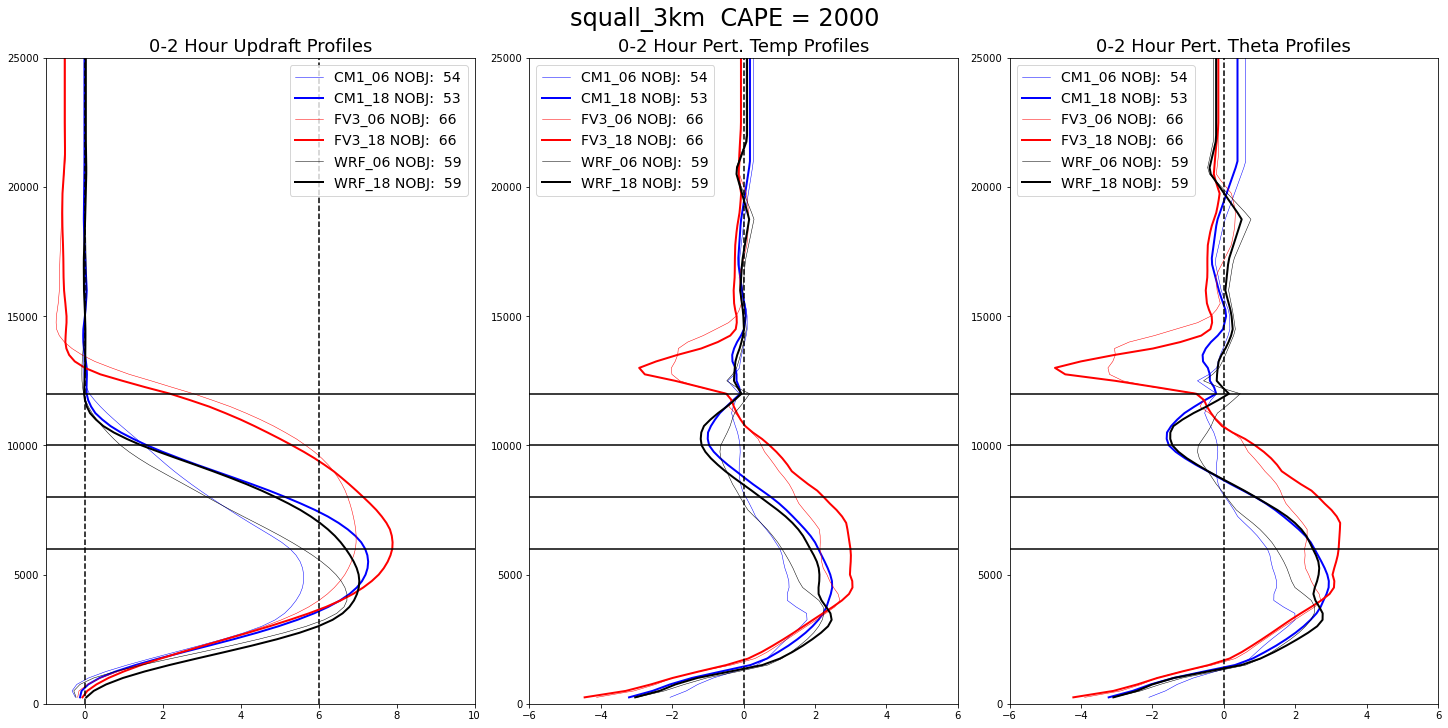

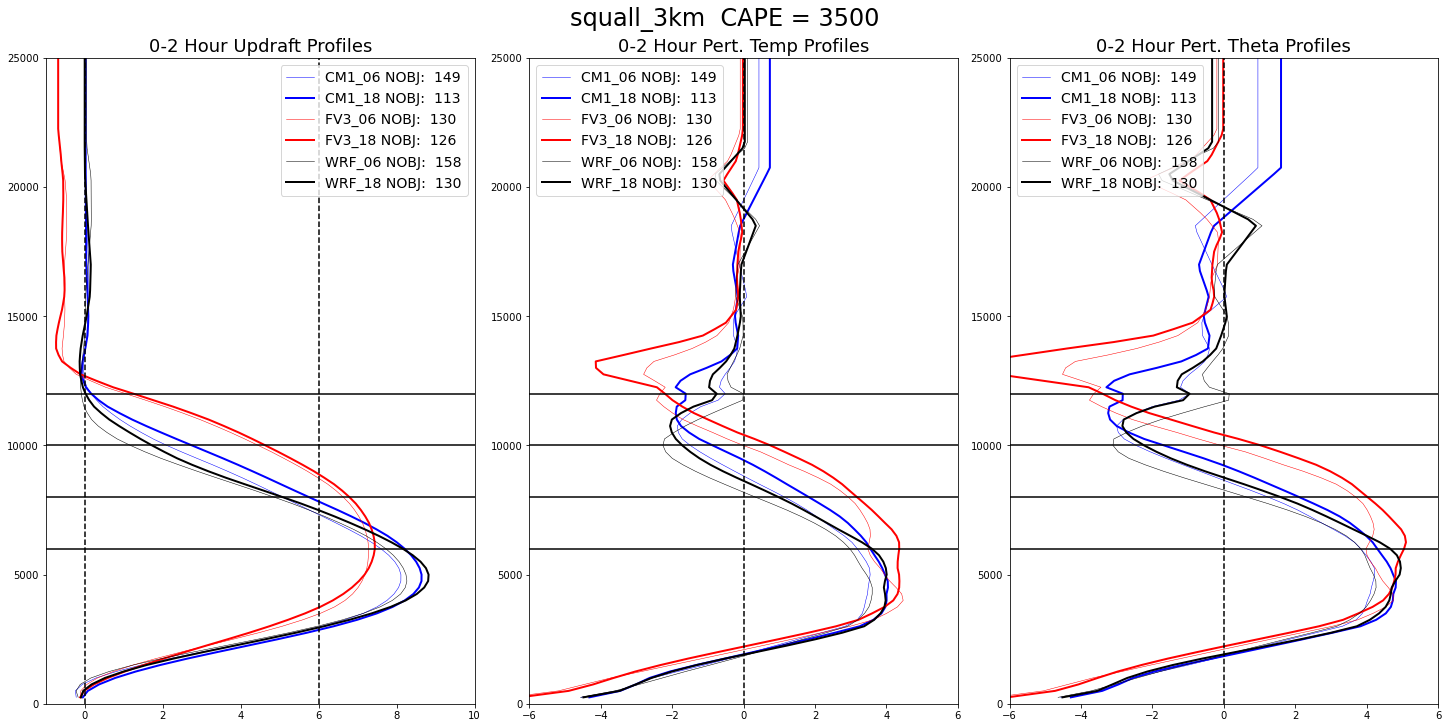

In [64]:
# Just read stuff back in...
            

plot_wptpth_driver( pickle2Obj('cm1_squall_3km_profiles.pkl',retObj=False), 
                    pickle2Obj('wrf_squall_3km_profiles.pkl',retObj=False),
                    pickle2Obj('solo_squall_3km_profiles.pkl',retObj=False), plabel = 'squall_3km' )





# # Just read stuff back in...
            
# plot_wprofile_driver( pickle2Obj('cm1_squall_noload_profiles.pkl',retObj=False), 
#                       pickle2Obj('wrf_squall_noload_profiles.pkl',retObj=False),
#                       pickle2Obj('solo_squall_3km_profiles.pkl',retObj=False), plabel = 'squall_NoLoad' )




In [263]:
#----------------------------------------------------
def plot_sizes_driver(cm1, wrf, solo, plabel=""):
    
    titles = ["0-2 Hour Updraft Sizes", "2-4 Hour Updraft Sizes", "4-6 Hour Updraft Sizes"]

    allcape = ("C2000", "C3500")
    allshear = ("06", "18")
    
    step = [[0,8],[8,16],[16,24]]

    for cape in allcape:

        for shear in allshear:   # create dictionary names
            
            label = "%s_%s" % (cape, shear)
            
            fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

            for n, s in enumerate(step):
                
                t0 = solo[label]['tindex'][s[0]]
                t1 = solo[label]['tindex'][s[1]]
                ss = np.sort(solo[label]['size'][t0:t1])

                t0 = wrf[label]['tindex'][s[0]]
                t1 = wrf[label]['tindex'][s[1]]
                ww = np.sort(wrf[label]['size'][t0:t1])
                
                t0 = cm1[label]['tindex'][s[0]]
                t1 = cm1[label]['tindex'][s[1]]
                cc = np.sort(cm1[label]['size'][t0:t1])               
        
                zsolo = np.arange(len(ss))/float(len(ss))

                zwrf = np.arange(len(ww))/float(len(ww))

                zcm1 = np.arange(len(cc))/float(len(cc))

                ax[n].plot(ss, zsolo, color='r', label='FV3_SOLO')
                ax[n].plot(ww, zwrf, color='k', label='WRF')

                ax[n].plot(cc, zcm1, color='b', label='CM1')

                ax[n].set_title("%s - (Updraft Size in Pixels)" % (titles[n]), fontsize=14)
                ax[n].axhline(y=0.5, color='k', linestyle='--')
                ax[n].axhline(y=0.9,  color='k', linestyle='--')

                ax[n].set_ylim(0.0,1.1)
                ax[n].set_xlim(0,50)
                ax[n].legend(fontsize=14, loc='lower right')
            
            plt.suptitle("%s" % (label), fontsize=18)


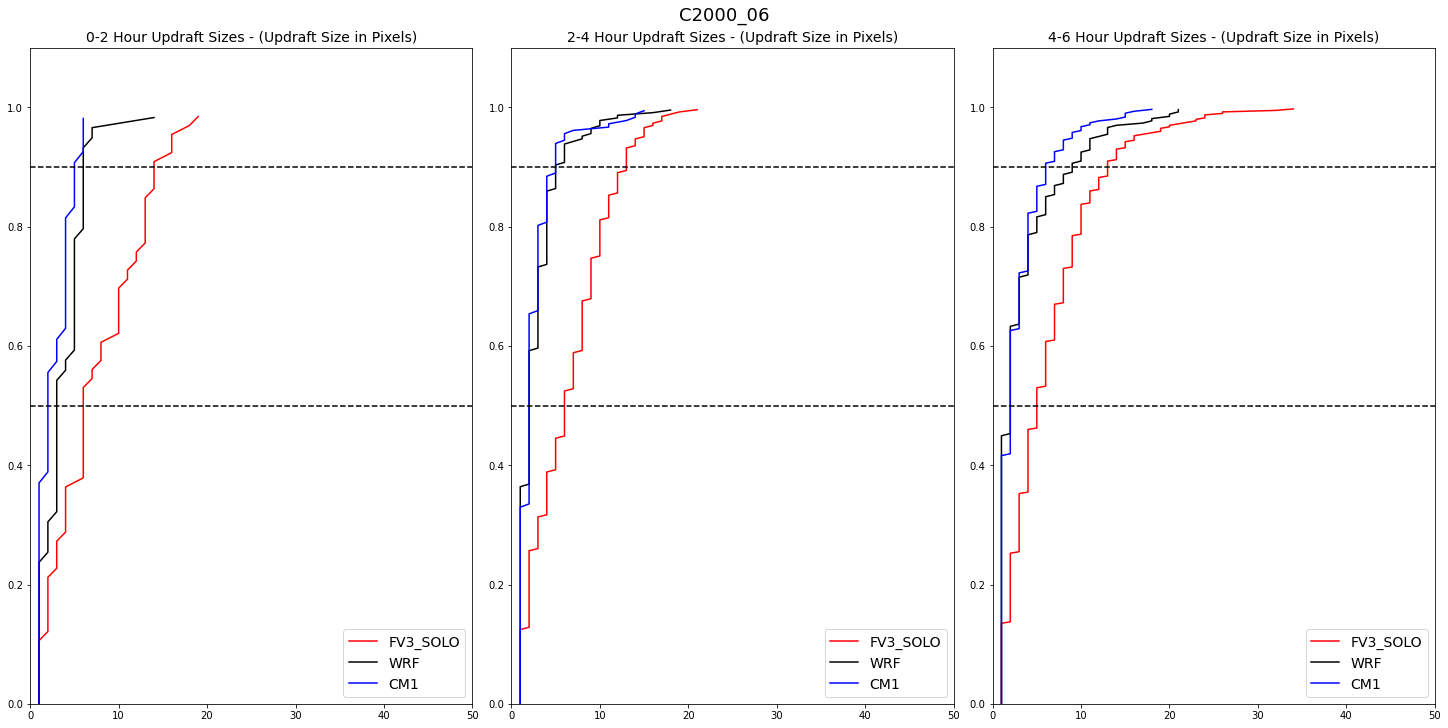

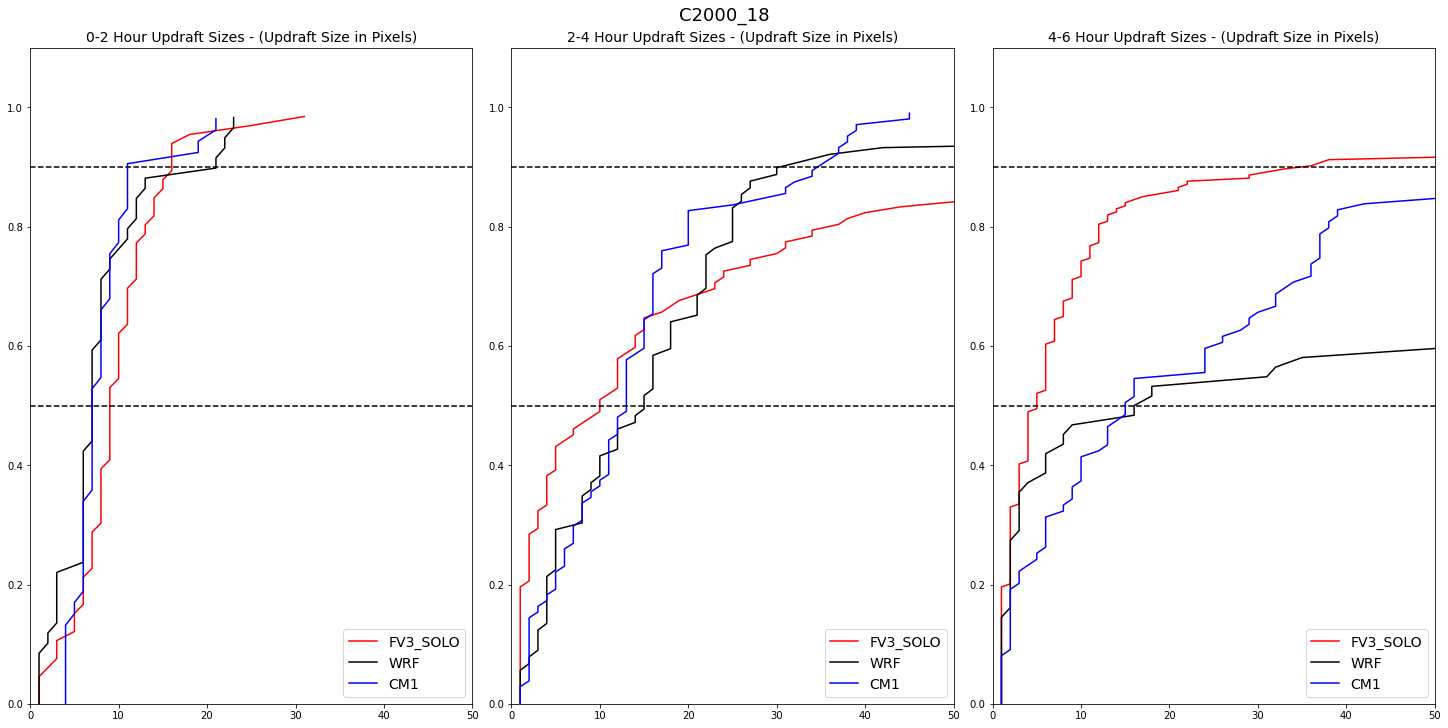

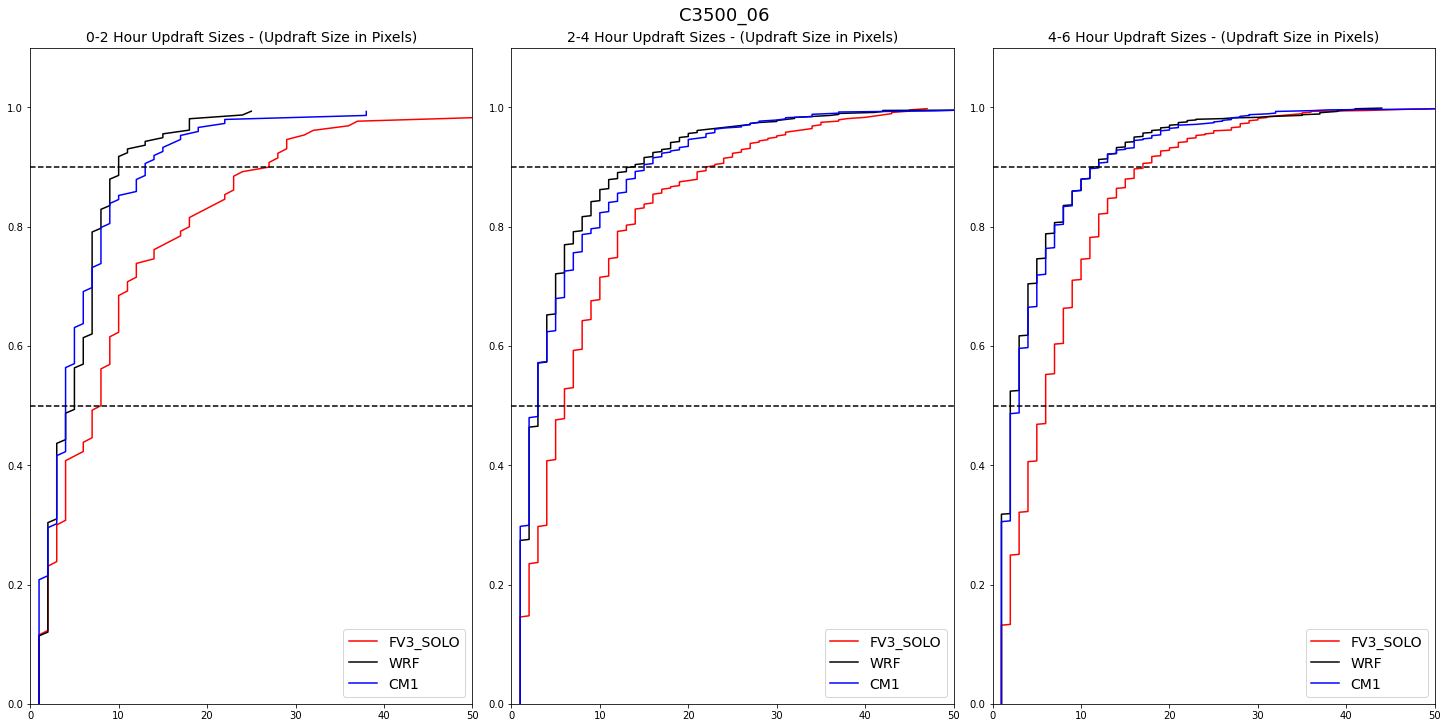

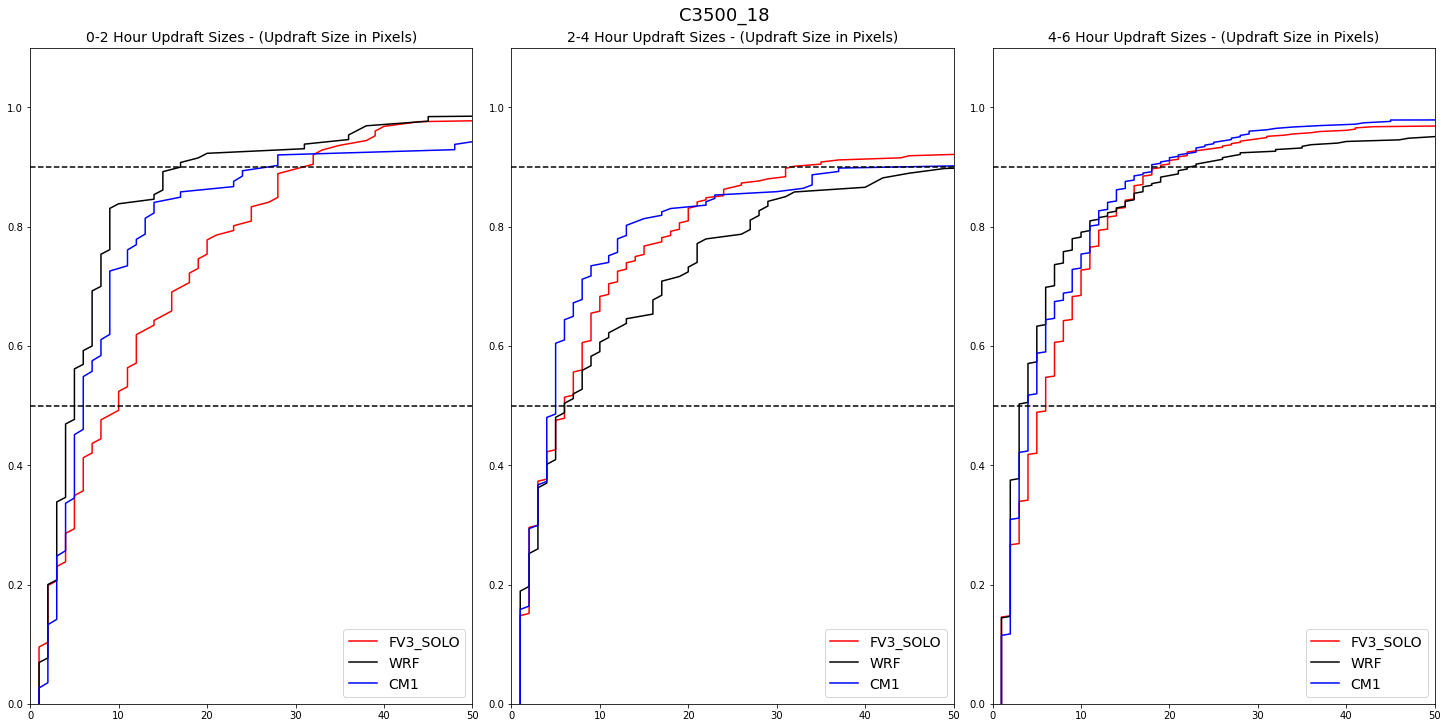

In [264]:

# # Just read stuff back in...
            
plot_sizes_driver( pickle2Obj('cm1_squall_3km_profiles.pkl',retObj=False), 
                   pickle2Obj('wrf_squall_3km_profiles.pkl',retObj=False),
                   pickle2Obj('solo_squall_3km_profiles.pkl',
                             ), plabel = 'squall_3km' )

